imports pakages

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions

from stable_baselines3 import A2C
from stable_baselines3 import DQN

import quantstats as qs

import matplotlib.font_manager as fm

建立环境

In [148]:
df = pd.read_csv("test.csv",encoding='gbk')
# 转换 'Date' 列为 pandas datetime 类型，并设置为 DataFrame 的索引
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,市场代码,合约代码,最新,持仓,增仓,成交额,Volume,开仓,平仓,成交类型,方向,买一价,Close,买一量,卖一量
Date,,,,,,,,,,,,,,,
2024-01-30 20:59:00.006,DC,a2403,4716.0,181672,134,35935920.0,762,448,314,空开,S,4716.0,4717.0,10,38
2024-01-30 21:00:00.255,DC,a2403,4716.0,181765,93,9809580.0,208,150,58,多开,B,4715.0,4716.0,335,2
2024-01-30 21:00:00.753,DC,a2403,4717.0,181576,-189,27978240.0,593,202,391,多平,S,4717.0,4718.0,35,4
2024-01-30 21:00:01.251,DC,a2403,4719.0,181579,3,6794310.0,144,73,71,多开,B,4718.0,4721.0,2,46
2024-01-30 21:00:01.753,DC,a2403,4719.0,181594,15,13544160.0,287,151,136,多开,B,4717.0,4720.0,31,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 14:59:56.718,DC,a2403,4745.0,162634,0,47450.0,1,0,1,空换,B,4743.0,4745.0,7,4
2024-01-31 14:59:57.619,DC,a2403,4743.0,162634,0,47430.0,1,0,1,多换,S,4743.0,4745.0,6,4
2024-01-31 14:59:58.105,DC,a2403,4745.0,162634,0,47450.0,1,0,1,空换,B,4743.0,4745.0,5,4


In [149]:
window_size = 10
start_index = window_size
end_index = len(df)

env = gym.make(
    'stocks-v0',
    df=df,
    window_size=window_size,
    frame_bound=(start_index, end_index)
)

print("observation_space:", env.observation_space)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())

observation_space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)
> max_possible_profit: 1.2504693225231076


训练

In [150]:
env.reset(seed = 2024)
model = DQN('MlpPolicy', env, verbose=0)
model.learn(total_timesteps=1_00000)

测试

In [151]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

observation, info = env.reset(seed = 2024)

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env.close()

print("action_stats:", action_stats)
print("info:", info)

action_stats: {<Actions.Sell: 0>: 391, <Actions.Buy: 1>: 14379}
info: {'total_reward': 26.0, 'total_profit': 0.0031881488547490554, 'position': <Positions.Long: 1>}


画图分析

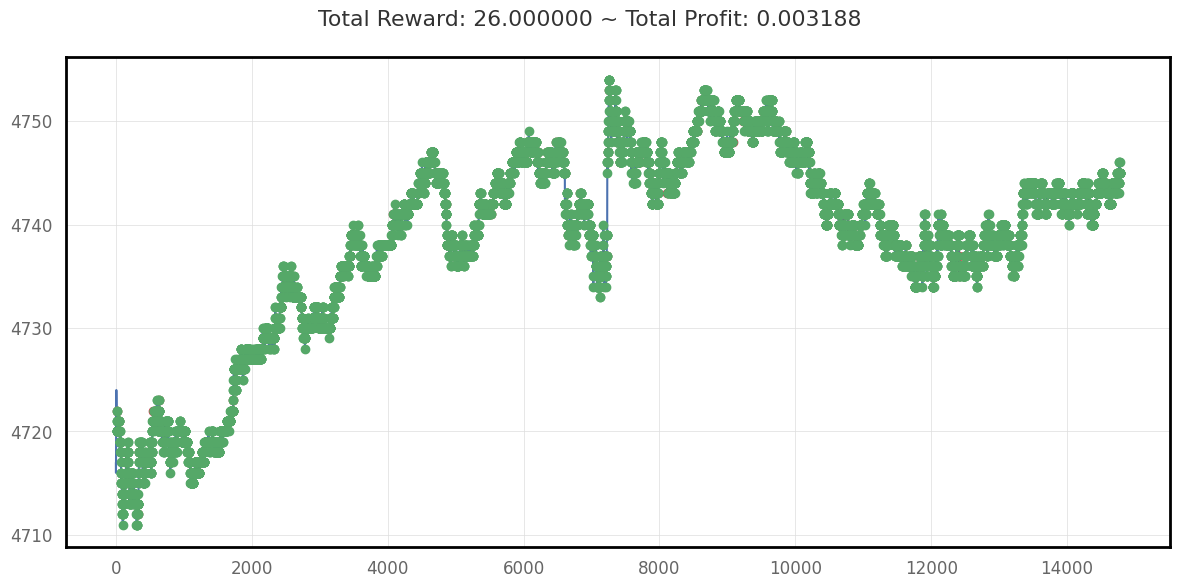

In [152]:
plt.figure(figsize=(12, 6))
env.unwrapped.render_all()

ax = plt.gca()  # 获取当前的Axes对象

# 显示所有spines（即保留上、下、左、右边框）
for spine in ax.spines.values():
    spine.set_visible(True)

# 设置spines的样式，如颜色、宽度等
for spine in ax.spines.values():
    spine.set_color('black')  # 设置颜色为黑色
    spine.set_linewidth(2)  # 设置线宽为2

# 使用 tight_layout() 调整子图间距和边距，确保数值标签不会被裁剪
plt.tight_layout()


# 保存为pdf文件
 # plt.savefig('output.pdf', format='pdf', bbox_inches='tight',dpi=300)

plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


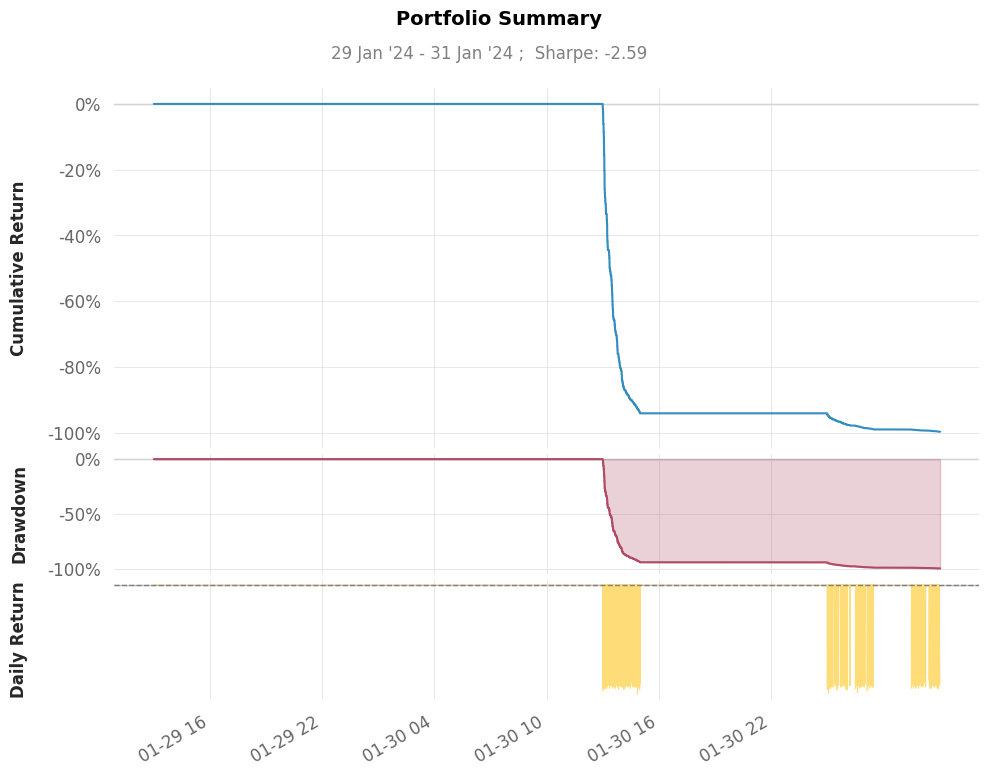

In [153]:
qs.extend_pandas()
net_worth = pd.Series(env.unwrapped.history['total_profit'], index=df.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.plots.snapshot(returns)


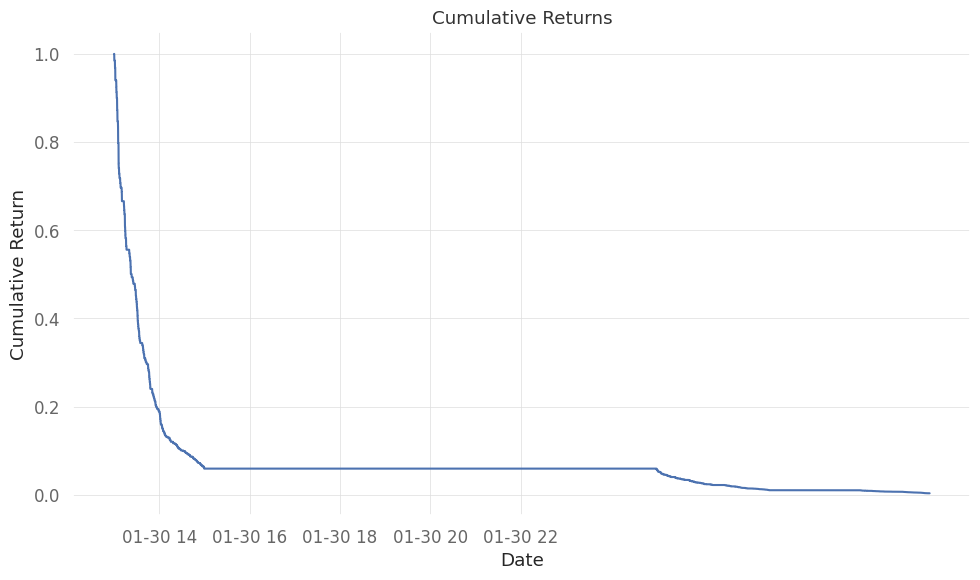

In [157]:
# 计算数据（以累计收益为例）
cumulative_returns = (1 + returns).cumprod()

# 使用Matplotlib绘制并保存
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns.index, cumulative_returns.values)
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.tight_layout()

# 保存图片
plt.savefig('cumulative_returns.png')

In [162]:
returns

Date
2024-01-30 21:00:05.735    0.000000
2024-01-30 21:00:06.243    0.000000
2024-01-30 21:00:06.748    0.000000
2024-01-30 21:00:07.251    0.000000
2024-01-30 21:00:07.716    0.000000
                             ...   
2024-01-31 14:59:56.718    0.000000
2024-01-31 14:59:57.619    0.000000
2024-01-31 14:59:58.105    0.000000
2024-01-31 14:59:58.546    0.000000
2024-01-31 15:02:39.978   -0.014742
Name: Strategy, Length: 14769, dtype: float64

In [156]:
net_worth

Date
2024-01-30 21:00:05.255    1.000000
2024-01-30 21:00:05.735    1.000000
2024-01-30 21:00:06.243    1.000000
2024-01-30 21:00:06.748    1.000000
2024-01-30 21:00:07.251    1.000000
                             ...   
2024-01-31 14:59:56.718    0.003236
2024-01-31 14:59:57.619    0.003236
2024-01-31 14:59:58.105    0.003236
2024-01-31 14:59:58.546    0.003236
2024-01-31 15:02:39.978    0.003188
Length: 14770, dtype: float64